In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, QTable
import astropy.constants as c
import os
import astropy.units as u
from scipy.interpolate import interp1d
from tdsat_telescope import load_telescope_parameters
from tdsat_sensitivity import src_rate, bgd_sky_qe_rate, bgd_electronics, calc_exposure
from astropy import log

try:
    from tdsat_sensitivity import calc_snr
except ImportError:
    def calc_snr(texp, src_rate, bgd_rate, read_noise, neff):
        """
        Compute S/N given the exposure time, source rate,
        the background rate, the read noise, and the number
        of effective background pixels and the number of stacked exposures
        -----

        snr = calc_snr(texp, src_rate, bgd_rate, read_noise, neff, nexp)

        """
        denom = (src_rate*texp + neff * (bgd_rate*texp + read_noise**2))**0.5
        nom = src_rate * texp
        snr = nom / denom
        return snr

from tdsat_neff import get_neff
from bbmag import bb_abmag_fluence, bb_abmag, sigerr
import numpy as np
from matplotlib import pyplot as plt

from astropy.visualization import quantity_support
import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)


In [2]:
#
# SHAMELESS COPY AND PASTE FROM MARIANNE'S NOTEBOOK
#
read_noise = 3.*(2**0.5) # Read noise for two frames

point_drift = 1*u.arcsec # To be added to the PSF in quadrature
point_jitter = 5*u.arcsec
# Define bands
td1_band = [193, 233]*u.nm


# Transmission efficiency
trans_eff = (0.975)**8 # from Jim. 

print('Transmission efficiency: {}'.format(trans_eff))

# Load telescope info
config=11
diameter, qe, psf_size, pixel_size, efficiency = load_telescope_parameters(config)

area = np.pi * (diameter*0.5)**2
area_onaxis = np.pi * (0.5*24.2*u.cm)**2
efficiency = area_onaxis / area

print('Effective area (used) {}'.format(area*efficiency))



# Add in fuzz...
psf_size = (psf_size**2 + point_drift**2 + point_jitter**2)**0.5


print('Effective PSF size {}'.format(psf_size))
# Get the number of effective background pixels
neff = get_neff(psf_size, pixel_size)
print('Number of effective bgd pixels: {}'.format(neff))
print()

Transmission efficiency: 0.8166518036622619
Telescope Configuration 11
Name: Small Focal Plane CMOS
Entrance Pupil diameter 26.0 cm
Optical Efficiency 0.7893639053254439
PSF FWHM 4.288 arcsec
Pixel size 6.4 arcsec
Effective Aperture 23.1 cm
Effective Area 419.09631397051237 cm2
Effective area (used) 459.9605804120816 cm2
Effective PSF size 6.6623527375845235 arcsec
Number of effective bgd pixels: 2.990374488245114



In [3]:
#
# MORE SHAMELESS COPY AND PASTE FROM MARIANNE'S NOTEBOOK
#

light=True
texp = 300*u.s
# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))

bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))


center_D1 = 208
width_D1 = 53
bandone=[center_D1 - 0.5*width_D1, center_D1+0.5*width_D1]*u.nm

center_D2 = 284
width_D2 = 68
bandtwo=[center_D2 - 0.5*width_D2, center_D2+0.5*width_D2]*u.nm

dist0 = 10*u.pc

Sky background rate per pixel band1: 0.030369732491096913 1 / s
Sky background rate per pixel band2: 0.2478588509265617 1 / s


In [4]:
def join_equal_gti_boundaries(gti):
    """If the start of a GTI is right at the end of another, join them.

    """
    new_gtis = gti
    touching = gti[:-1, 1] == gti[1:, 0]
    if np.any(touching):
        ng = []
        count = 0
        while count < len(gti) - 1:
            if new_gtis[count, 1] == gti[count + 1, 0]:
                ng.append([gti[count, 0], gti[count + 1, 1]])
            else:
                ng.append(gti[count])
            count += 1
        new_gtis = np.asarray(ng)
    return new_gtis


def cross_two_gtis(gti0, gti1):
    """Extract the common intervals from two GTI lists *EXACTLY*.
    
    From Stingray

    Parameters
    ----------
    gti0 : iterable of the form ``[[gti0_0, gti0_1], [gti1_0, gti1_1], ...]``
    gti1 : iterable of the form ``[[gti0_0, gti0_1], [gti1_0, gti1_1], ...]``
        The two lists of GTIs to be crossed.

    Returns
    -------
    gtis : ``[[gti0_0, gti0_1], [gti1_0, gti1_1], ...]``
        The newly created GTIs

    See Also
    --------
    cross_gtis : From multiple GTI lists, extract common intervals *EXACTLY*

    Examples
    --------
    >>> gti1 = np.array([[1, 2]])
    >>> gti2 = np.array([[1, 2]])
    >>> newgti = cross_gtis([gti1, gti2])
    >>> np.all(newgti == [[1, 2]])
    True
    >>> gti1 = np.array([[1, 4]])
    >>> gti2 = np.array([[1, 2], [2, 4]])
    >>> newgti = cross_gtis([gti1, gti2])
    >>> np.all(newgti == [[1, 4]])
    True
    """
    gti0 = join_equal_gti_boundaries(np.asarray(gti0))
    gti1 = join_equal_gti_boundaries(np.asarray(gti1))
#     # Check GTIs
#     check_gtis(gti0)
#     check_gtis(gti1)

    gti0_start = gti0[:, 0]
    gti0_end = gti0[:, 1]
    gti1_start = gti1[:, 0]
    gti1_end = gti1[:, 1]

    # Create a list that references to the two start and end series
    gti_start = [gti0_start, gti1_start]
    gti_end = [gti0_end, gti1_end]

    # Concatenate the series, while keeping track of the correct origin of
    # each start and end time
    gti0_tag = np.array([0 for g in gti0_start], dtype=bool)
    gti1_tag = np.array([1 for g in gti1_start], dtype=bool)
    conc_start = np.concatenate((gti0_start, gti1_start))
    conc_end = np.concatenate((gti0_end, gti1_end))
    conc_tag = np.concatenate((gti0_tag, gti1_tag))

    # Put in time order
    order = np.argsort(conc_end)
    conc_start = conc_start[order]
    conc_end = conc_end[order]
    conc_tag = conc_tag[order]

    last_end = conc_start[0] - 1
    final_gti = []
    for ie, e in enumerate(conc_end):
        # Is this ending in series 0 or 1?
        this_series = int(conc_tag[ie])
        other_series = int(this_series == 0)

        # Check that this closes intervals in both series.
        # 1. Check that there is an opening in both series 0 and 1 lower than e
        try:
            st_pos = \
                np.argmax(gti_start[this_series][gti_start[this_series] < e])
            so_pos = \
                np.argmax(gti_start[other_series][gti_start[other_series] < e])
            st = gti_start[this_series][st_pos]
            so = gti_start[other_series][so_pos]

            s = np.max([st, so])
        except:  # pragma: no cover
            continue

        # If this start is inside the last interval (It can happen for equal
        # GTI start times between the two series), then skip!
        if s <= last_end:
            continue
        # 2. Check that there is no closing before e in the "other series",
        # from intervals starting either after s, or starting and ending
        # between the last closed interval and this one
        cond1 = (gti_end[other_series] > s) * (gti_end[other_series] < e)
        cond2 = gti_end[other_series][so_pos] < s
        condition = np.any(np.logical_or(cond1, cond2))
        # Well, if none of the conditions at point 2 apply, then you can
        # create the new gti!
        if not condition:
            final_gti.append([s, e])
            last_end = e

    return np.array(final_gti)

In [5]:
def get_visibility_windows(observation_start : float, observation_end : float, 
                           orbital_period : float = 96. * 60, 
                           exposure_per_orbit : float = 35. * 60,
                           phase_start : float = 0.):
    """Observing windows of a given target over multiple orbits.
    
    All quantities are defined in seconds. 
    This function is unit-agnostic.
    
    Parameters
    ----------
    observation_start : float
        Observation start in seconds
    observation_end : float
        Observation end in seconds
        
    Other parameters
    ----------------
    orbital_period : float, default 96 mins
        Orbital period of the satellite, in seconds
    exposure_per_orbit : float, default 35 mins
        Time spent on a given target during an orbit, in seconds
    phase_start : float, default 0
        Orbital phase at which a target is observed
        
    
    Examples
    --------
    >>> ow = get_observing_windows(0, 5760 * 2)
    >>> np.allclose(ow, [[0, 2100], [5760, 7860]])
    True
    """
    tstart = observation_start + orbital_period * phase_start
    start_times = np.arange(tstart, observation_end + orbital_period, orbital_period)
    end_times = start_times + exposure_per_orbit
    obs_windows = np.array(list(zip(start_times, end_times)))
    good = (start_times < observation_end)
    obs_windows[end_times > observation_end] = observation_end
    
    return obs_windows[good]
    

In [6]:
def calculate_flux(time : float, flux : float):
    """This is unit-agnostic, by choice."""
    dt = np.mean(np.diff(time))
    return np.sum(flux * dt) / (time[-1] - time[0])


def calculate_lightcurve_from_model(model_time, model_lc, observing_windows=None, 
                                    visibility_windows=None,
                                    exposure_length=300 * u.s, **kwargs):
    """Calculate a light curve from the model lightcurve in ct/s.
    
    Parameters
    ----------
    model_time : ``astropy.units.s``
        Times at which the model is calculated
    model_lc : any ``astropy.units`` object expressing flux
        Values of the model
        
    Other parameters
    ----------------
    visibility_windows : [[start0, end0], [start1, end1], ...], ``astropy.units.s``, default None
        Visibility windows in seconds
    observing_windows : [[start0, end0], [start1, end1], ...], ``astropy.units.s``, default None
        Observing times in seconds
    exposure_length : ``astropy.units.s``, default 300 s
        Time for each exposure
    **kwargs : 
        Additional keyword arguments to be passed to 
        ``get_observing_windows``
    """
    import collections
    observing_windows = np.array([[model_time[0].to(u.s).value, model_time[-1].to(u.s).value]]) * u.s \
        if observing_windows is None else observing_windows

    if visibility_windows is None:
        visibility_windows = \
            get_visibility_windows(observing_windows.min().to(u.s).value, 
                                   observing_windows.max().to(u.s).value, **kwargs) * u.s

    observing_windows = cross_two_gtis(observing_windows, visibility_windows) * u.s
    
    interpolated_lc = interp1d(model_time.to(u.s).value, 
                               model_lc.value, fill_value=0, bounds_error=False)
    times = []
    lc = []
    for ow in observing_windows:
        expo_times = np.arange(ow[0].value, ow[1].value, exposure_length.value) * u.s
        for t in expo_times:
            times.append((t + exposure_length / 2).to(u.s).value)
            fine_times = np.linspace(t.value, (t + exposure_length).value, 10)
            fine_model = interpolated_lc(fine_times)
            flux = calculate_flux(fine_times * u.s, fine_model)
            lc.append(flux)

    result_table = QTable()
    result_table['Time'] = np.array(times) * u.s
    result_table['Light curve'] = np.array(lc) * model_lc.unit

    return result_table

In [7]:
def calculate_snr(lc, dist=10 * u.pc, background=bgd_band1):   
    """Calculate the signal to noise ratio of from photon fluxes."""
    band_fluence = lc *(dist0.to(u.pc)/dist.to(u.pc))**2
    band_rate = trans_eff * efficiency * area * band_fluence
    lc_snr = calc_snr(texp, band_rate, background, 
                      read_noise, neff)
    return lc_snr


def get_lightcurve(input_lc_file, distance=10*u.pc, observing_windows=None):
    """Get a realistic light curve from a given theoretical light curve.
    
    Parameters
    ----------
    input_lc_file : str
        Light curve file containing photon fluxes
    
    Other parameters
    ----------------
    distance : ``astropy.units.pc``
        Distance of the SN event
    observing_windows : [[start0, end0], [start1, end1], ...], ``astropy.units.s``, default None
        Observing times in seconds
    """
    fname, ext = os.path.splitext(input_lc_file)
    if ext == '.asc':
        model_lc_table = QTable()
        _mlt = Table.read(input_lc_file, format='ascii')
        model_lc_table['Time'] = _mlt['Time'] * u.s
        model_lc_table['photflux_D1'] = _mlt['photonflux_D1'] * (1 / u.s)
        model_lc_table['photflux_D2'] = _mlt['photonflux_D2'] * (1 / u.s)
    else:
        model_lc_table = QTable.read(input_lc_file)

    table_photflux_D1 = \
        calculate_lightcurve_from_model(model_lc_table['Time'], model_lc_table['photflux_D1'], 
                                        exposure_length=300 * u.s,
                                        observing_windows=observing_windows)
    table_photflux_D2 = \
        calculate_lightcurve_from_model(model_lc_table['Time'], model_lc_table['photflux_D2'], 
                                        exposure_length=300 * u.s,
                                        observing_windows=observing_windows)
    result_table = QTable()
    result_table['Time'] = table_photflux_D1['Time']
    result_table['photflux_D1'] = table_photflux_D1['Light curve']
    result_table['photflux_D2'] = table_photflux_D2['Light curve']
    result_table['snr_D1'] = calculate_snr(table_photflux_D1['Light curve'], distance,
                                           background=bgd_band1)
    result_table['snr_D2'] = calculate_snr(table_photflux_D2['Light curve'], distance,
                                           background=bgd_band2)
    
    flux_D1 = \
        table_photflux_D1['Light curve'] * c.h * c.c / np.mean(bandone)
    flux_D2 = \
        table_photflux_D2['Light curve'] * c.h * c.c / np.mean(bandtwo)
    
    flux_density_D1 = flux_D1 / (bandone[1] - bandone[0]) *(dist0.to(u.pc)/distance.to(u.pc))**2
    flux_density_D2 = flux_D2 / (bandtwo[1] - bandtwo[0]) *(dist0.to(u.pc)/distance.to(u.pc))**2
    
    result_table['ABmag_D1'] = \
        flux_density_D1.to(u.ABmag, 
                           equivalencies=u.spectral_density(np.mean(bandone)))
    result_table['ABmag_D2'] = \
        flux_density_D2.to(u.ABmag, 
                           equivalencies=u.spectral_density(np.mean(bandtwo)))
        
    result_table['ABmag_D1_err'] = sigerr(result_table['snr_D1'])
    result_table['ABmag_D2_err'] = sigerr(result_table['snr_D2'])

    return result_table

In [8]:
def create_and_plot_lc(*args, **kwargs):
    lightcurve = get_lightcurve(*args, **kwargs)
    plt.figure(figsize=(15, 8))
    gs = plt.GridSpec(2, 1, hspace=0)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)
    good = (lightcurve['snr_D1'].value > 1) | (lightcurve['snr_D2'].value > 1)
    lightcurve = lightcurve[good]
    ax0.errorbar(lightcurve['Time'].value / 86400, lightcurve['ABmag_D1'].value, 
                 fmt='o', markersize=2, yerr=lightcurve['ABmag_D1_err'].value)
    ax0.errorbar(lightcurve['Time'].value / 86400, lightcurve['ABmag_D2'].value, 
                 fmt='o', markersize=2, yerr=lightcurve['ABmag_D2_err'].value)
    ax1.scatter(lightcurve['Time'].value / 86400, lightcurve['snr_D1'].value, s=2)
    ax1.scatter(lightcurve['Time'].value / 86400, lightcurve['snr_D2'].value, s=2)

    ax0.set_ylabel("AB mag")
    ax1.set_ylabel("S/R")
    ax1.set_xlabel("Time (d)")
    ymin = min(lightcurve['ABmag_D1'].value.min(), lightcurve['ABmag_D2'].value.min()) - 1
    ymax = max(lightcurve['ABmag_D1'].value.max(), lightcurve['ABmag_D2'].value.max()) + 1
    # Inverted ax for magnitude
    ax0.set_ylim([ymax, ymin])
    ax1.semilogx();
    

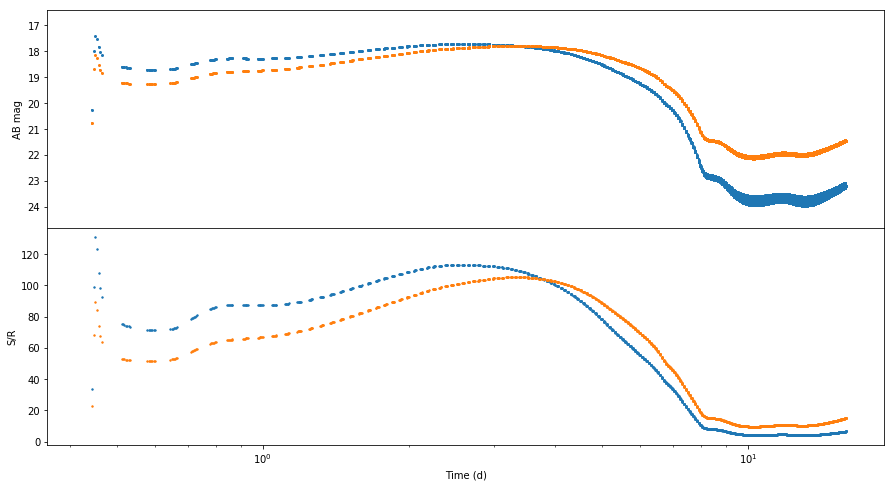

In [9]:
create_and_plot_lc("input_data/SNIIb_lightcurve_DUET.fits", distance=100e6*u.pc)

Now specifying the observing window...

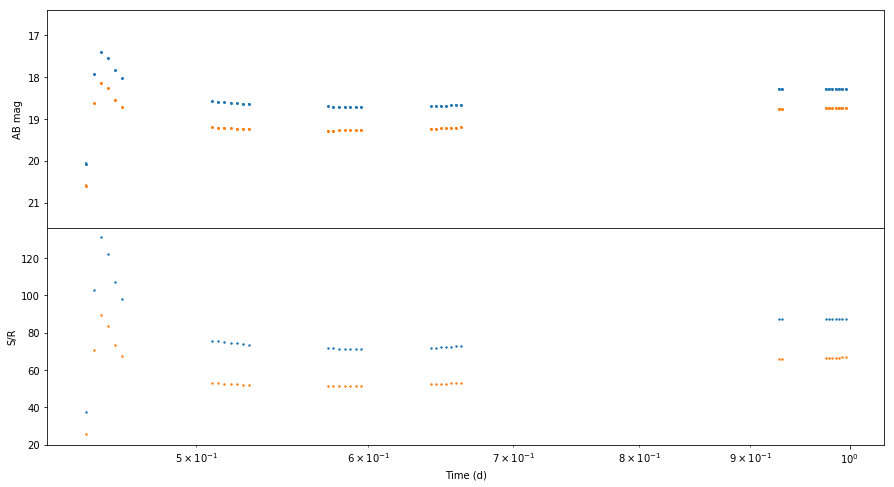

In [10]:
create_and_plot_lc("input_data/SNIIb_lightcurve_DUET.fits", distance=100e6*u.pc,
                  observing_windows=np.array([[38000, 60000], [80000, 90000]])*u.s)